In [1]:
import scipy.io
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.spatial import distance
from geopy.distance import geodesic
import geopy.point as point
from tools import *
from pylab import *

# Map configs

In [2]:
base = './dataset/{location}_cell.mat'

london_20 = 'london_square'
london_5 = 'london_square_5'
london_10 = 'london_square_10'
london_50 = 'london_square_50'

config_ls = [london_5, london_10, london_20, london_50]

gs_ls = 1000 / np.array([50, 20, 10, 5])

In [3]:
meta_df = {}
cirs = {}
Y_all = {}
RX_all = {}

In [4]:
for config in config_ls:
    meta_df[config], cirs[config], _, Y_all[config], RX_all[config], _, _ = read_mat(config)

# Data preparation

In [5]:
meta_data_20, cir_profile_20, _, Y_20, RX_20, _, _ = read_mat(london_20)
meta_data_10, cir_profile_10, _, Y_10, RX_10, _, _ = read_mat(london_10)
meta_data_50, cir_profile_50, _, Y_50, RX_50, _, _ = read_mat(london_50)
meta_data_5, cir_profile_5, _, Y_5, RX_5, _, _ = read_mat(london_5)

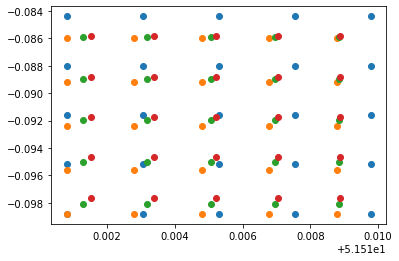

In [7]:
for rx in RX_all.values():
    plot_agent(rx)

In [11]:
X_all = {}
features = {}
for config in config_ls:
    features[config] = Extractor(cirs[config])
    X_all[config] = features[config].formatting_X()


d:\Telecom_2eme_anne\Geolocation_simulation\Simulation\tools.py:95: ComplexWarning: Casting complex values to real discards the imaginary part
  self.mag = - math.floor(math.log(np.mean(self.delay_set), 10))
d:\Telecom_2eme_anne\Geolocation_simulation\Simulation\tools.py:116: ComplexWarning: Casting complex values to real discards the imaginary part
  cir_t.append(np.array(cir_shaped, dtype='float'))


In [12]:
X_all_amp = {}
for config in config_ls:
    X_all_amp[config] = Extractor(cirs[config]).amplitute_feature()

# Training

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_validate
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor as RF
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.pipeline import Pipeline
import seaborn as sns
import lightgbm as lgb

## Build pipes

In [13]:
xgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('xgb', MultiOutputRegressor(xgb.XGBRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

lgb_pipe = Pipeline([('scale', StandardScaler()), \
    ('lgb', MultiOutputRegressor(lgb.LGBMRegressor(n_estimators=500, max_depth=2000, eta=0.1, subsample=1, colsample_bytree=1, reg_lambda=0)))])

rf_pipe = Pipeline([('scale', StandardScaler()), ('rf', RF(max_depth=2000))])

dt_pipe = Pipeline([('scale', StandardScaler()), ('dt', DT(max_depth=2000))])

In [14]:
# GridSearchCV(xgb_pipe)

In [15]:
pipes = [xgb_pipe, lgb_pipe, rf_pipe, dt_pipe]
model_ls = ['XGB', 'LGBM', 'RF', 'DT']

In [16]:
pipes_fitting = {}

for config in config_ls:
    pipes_fitting[config] = PipesFitting(X_all[config], Y_all[config], RX_all[config])
    pipes_fitting[config].add_pipes(pipes, model_ls)
    pipes_fitting[config].fit()

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


In [17]:
pipes_fitting_amp = {}

for config in config_ls:
    pipes_fitting_amp[config] = PipesFitting(X_all_amp[config], Y_all[config], RX_all[config])
    pipes_fitting_amp[config].add_pipes(pipes, model_ls)
    pipes_fitting_amp[config].fit()

[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] learning_rate is set=0.1, eta=0.1 will be ignored. Current value: learning_rate=0.1


## Box plot for each configs

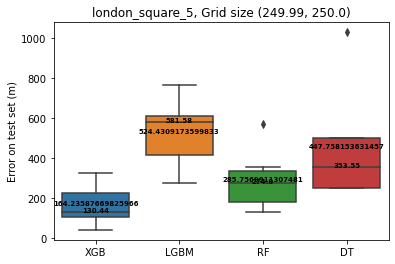

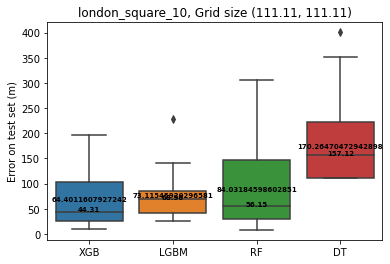

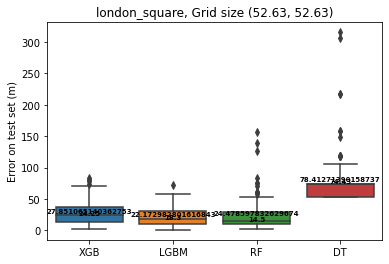

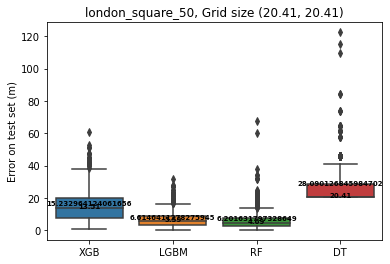

In [14]:
for config, pp in pipes_fitting.items():
    plt.figure()
    tmp = VisualizeResult(pp, config)
    tmp.boxplot_pipes()
    # plt.title(config)

In [27]:
for i in pipes_fitting_amp:
    print(i)

pipes_fitting_amp.items()

london_square_5
london_square_10
london_square
london_square_50


dict_items([('london_square_5', <tools.PipesFitting object at 0x0000022B53190648>), ('london_square_10', <tools.PipesFitting object at 0x0000022B50F623C8>), ('london_square', <tools.PipesFitting object at 0x0000022B5319D148>), ('london_square_50', <tools.PipesFitting object at 0x0000022B498EFBC8>)])

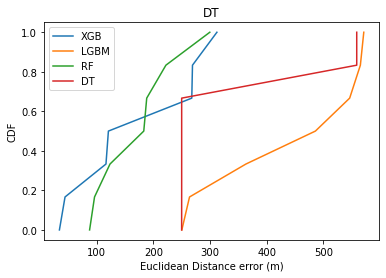

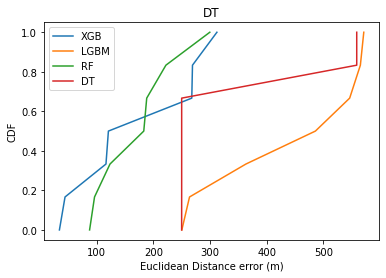

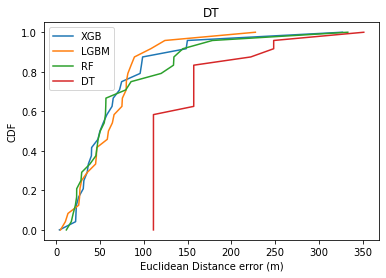

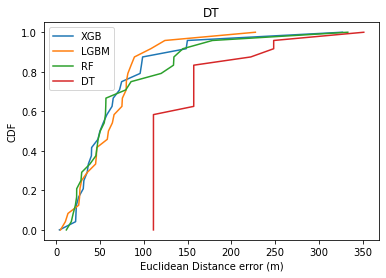

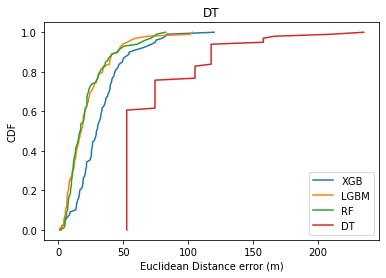

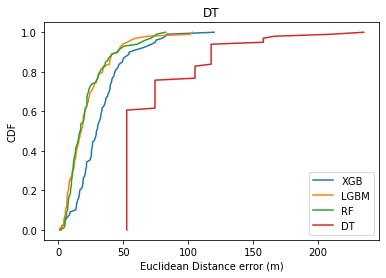

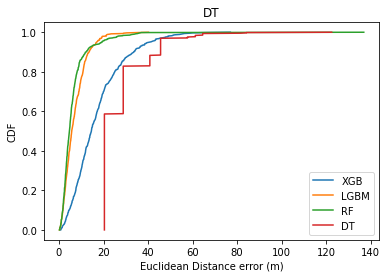

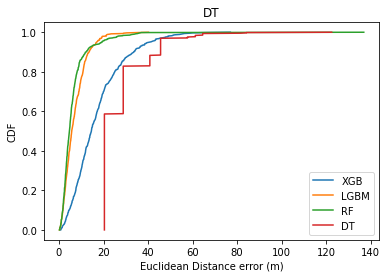

In [18]:
for p1, p2 in zip(pipes_fitting.items(), pipes_fitting_amp.items()):
    plt.figure()
    tmp = VisualizeResult(p1[1], p1[0])
    tmp2 = VisualizeResult(p2[1], p2[0])
    tmp.cdf_plot()
    plt.figure()
    tmp.cdf_plot()
    # plt.title(config)

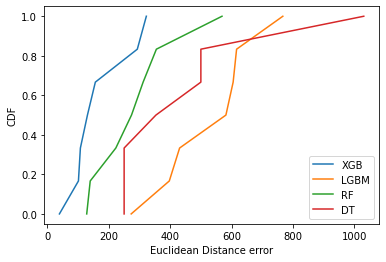

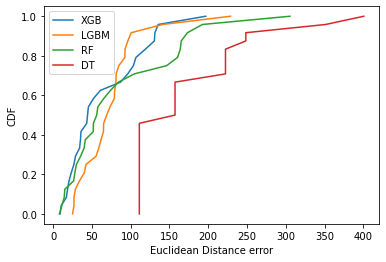

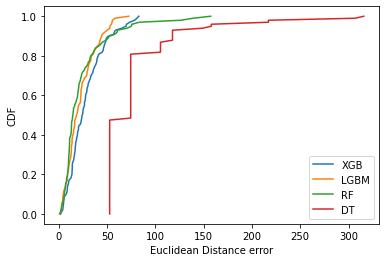

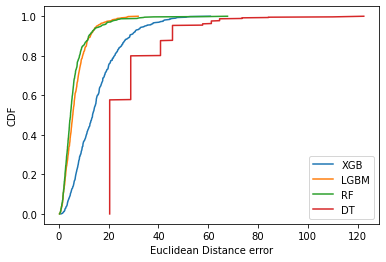

In [18]:
for config, pp in pipes_fitting.items():
    plt.figure()
    tmp = VisualizeResult(pp, config)
    tmp.cdf_plot()
    # plt.title(config)

<Figure size 432x288 with 0 Axes>

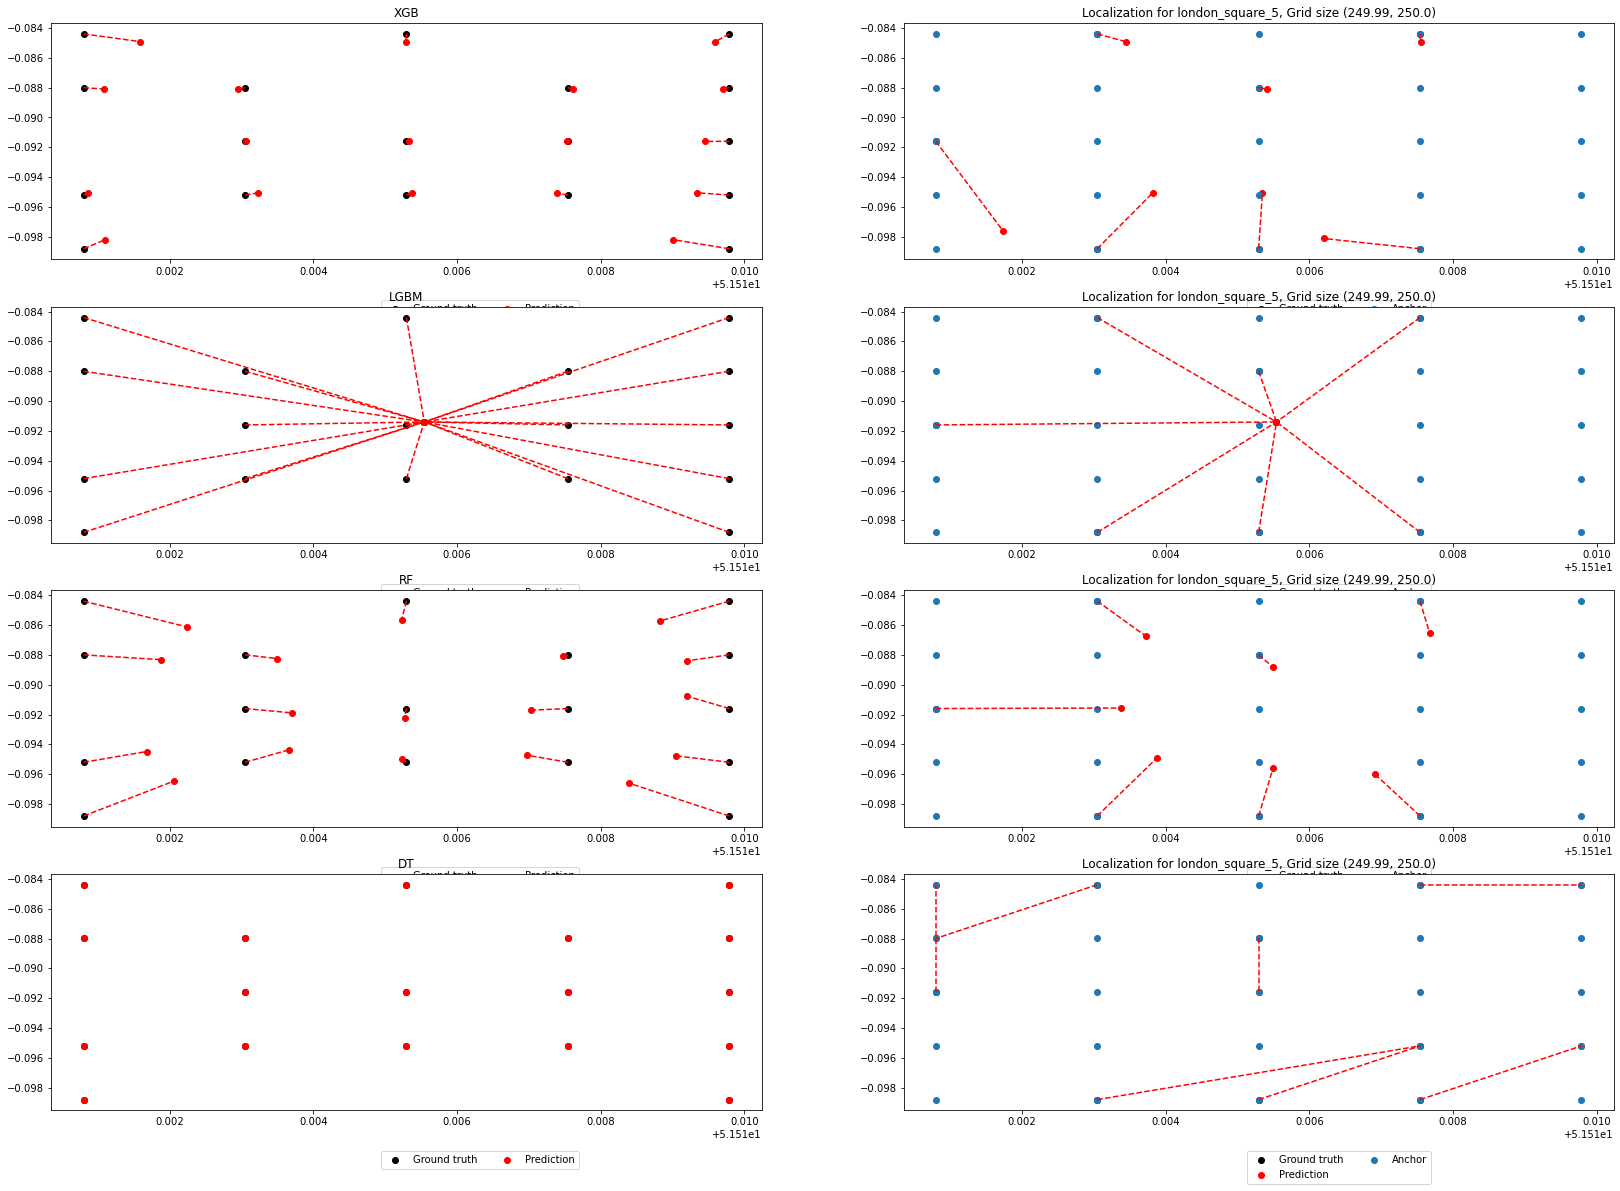

<Figure size 432x288 with 0 Axes>

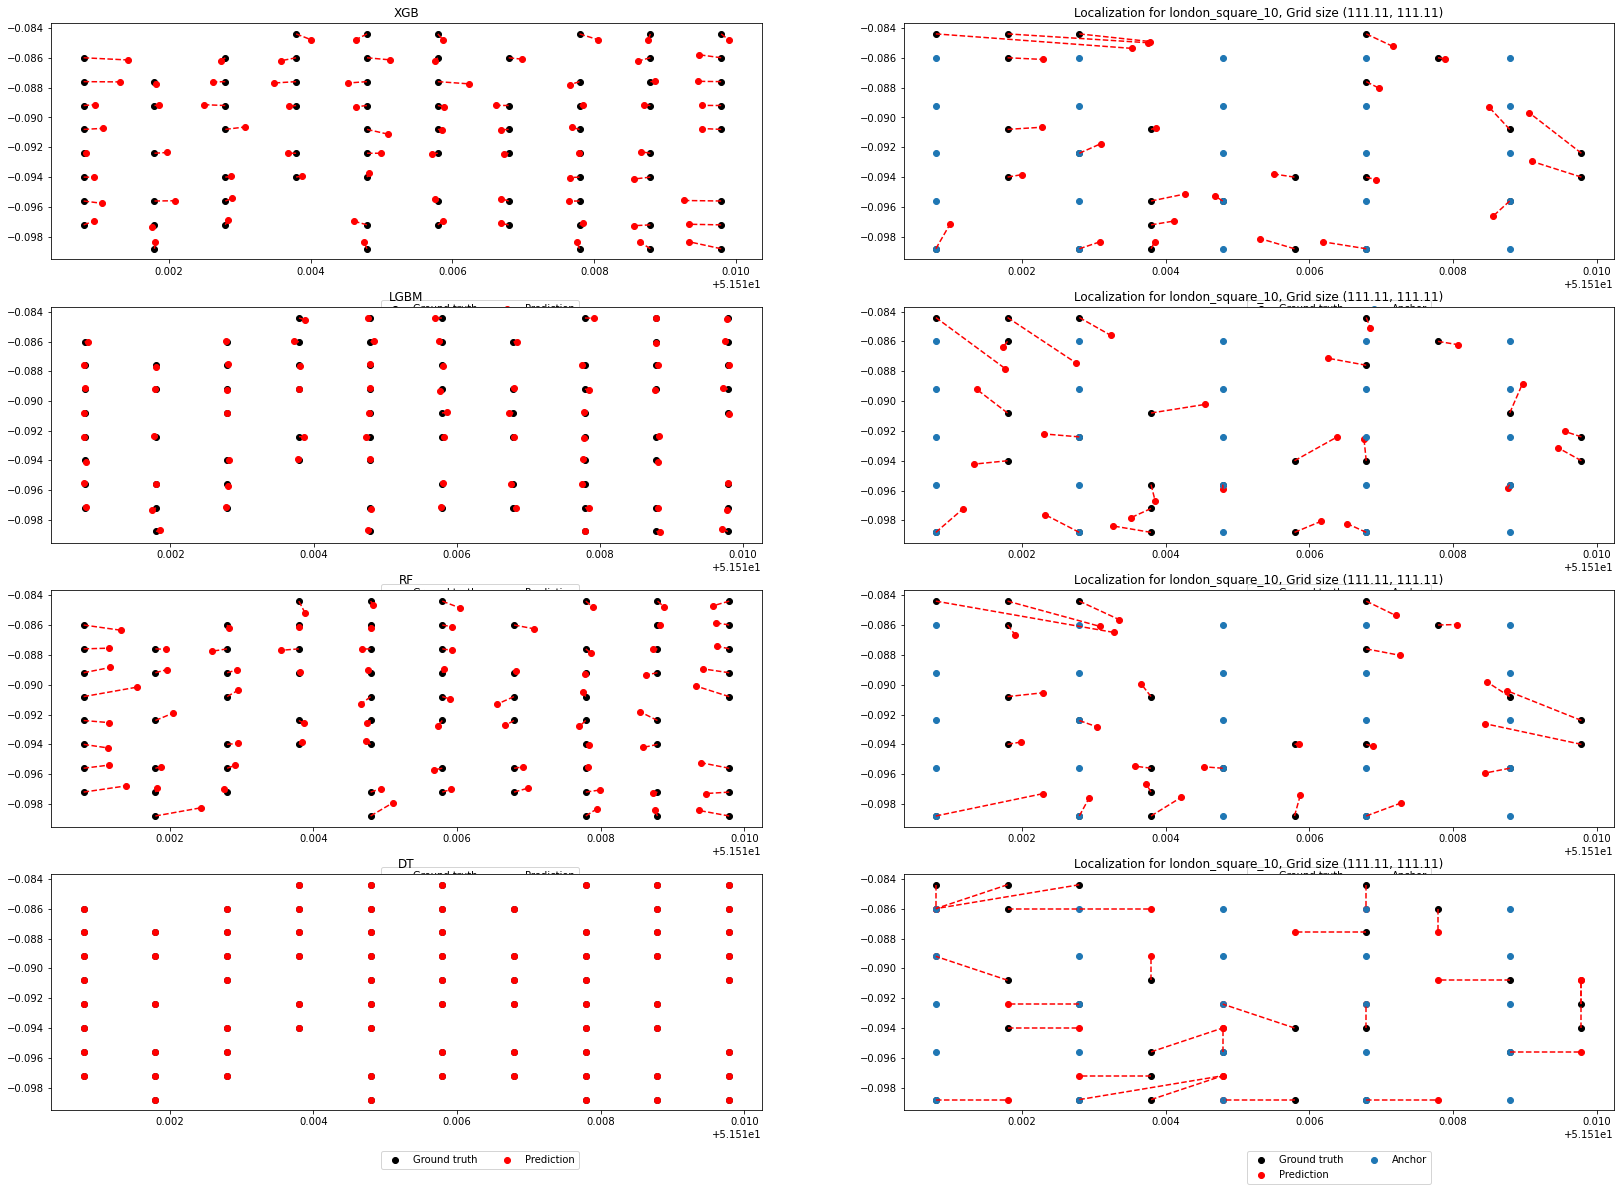

<Figure size 432x288 with 0 Axes>

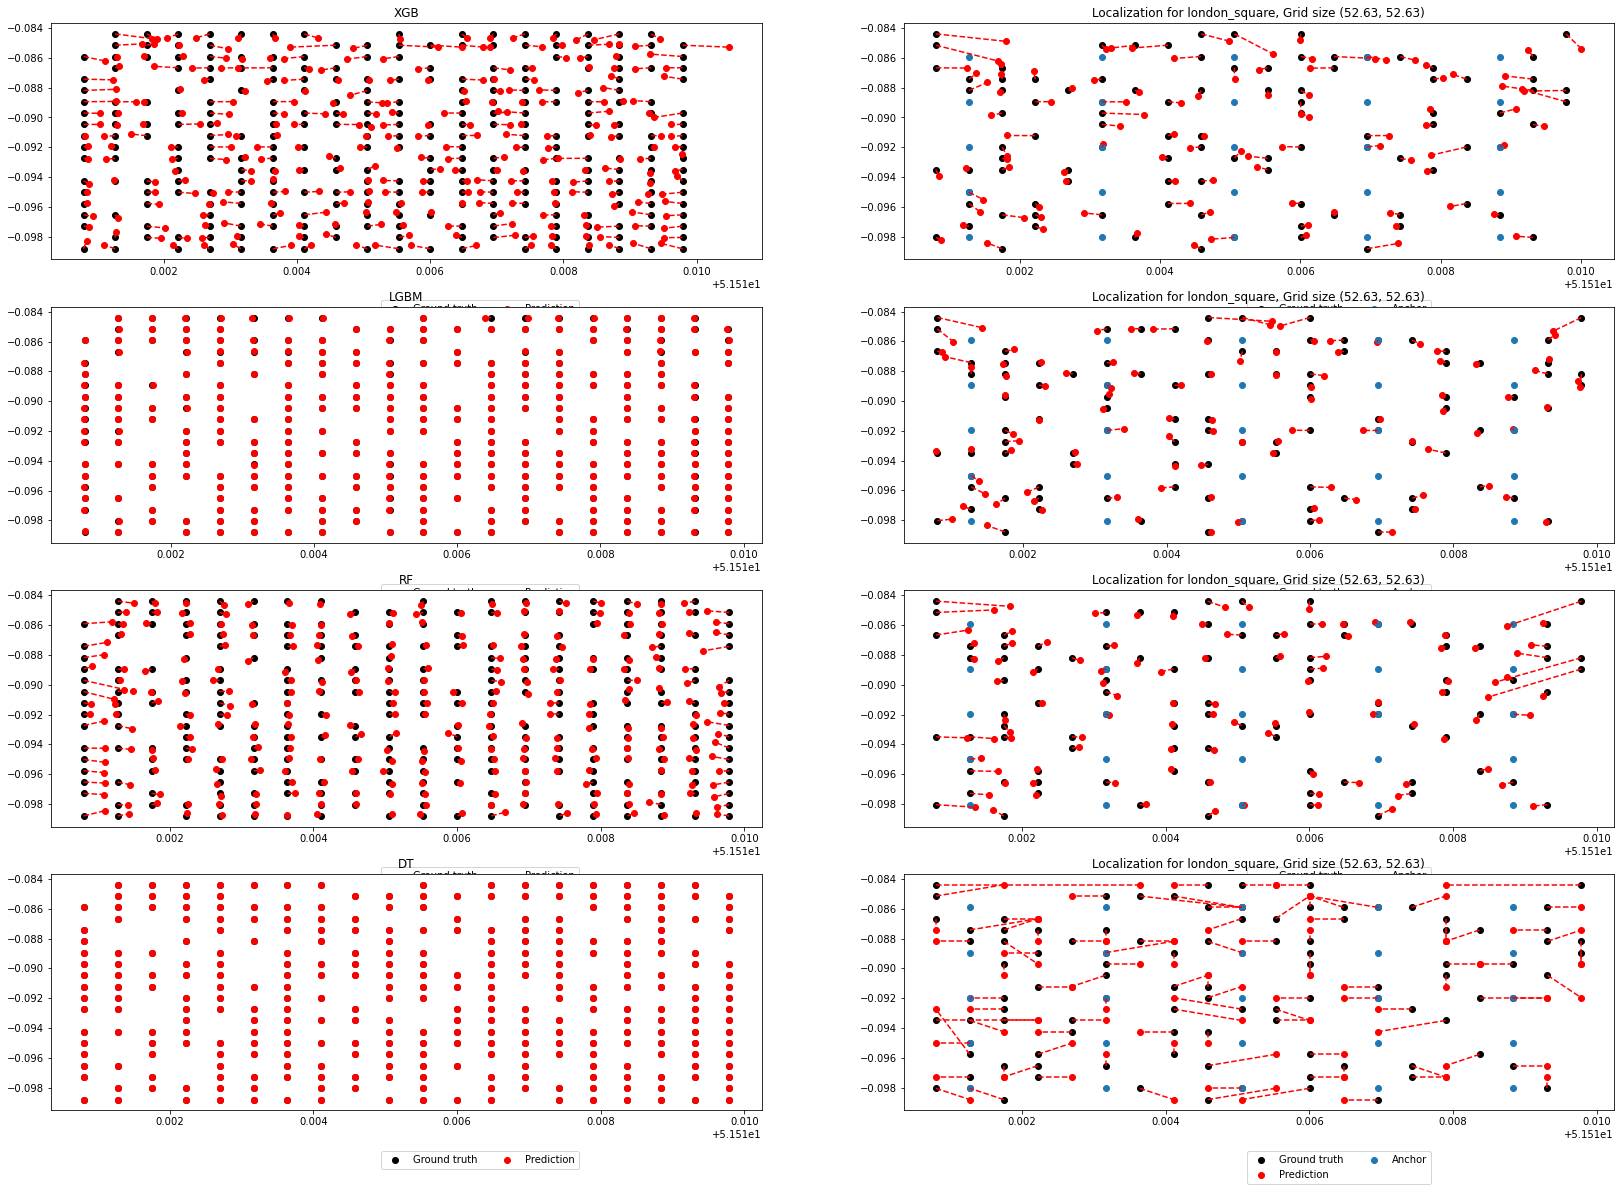

<Figure size 432x288 with 0 Axes>

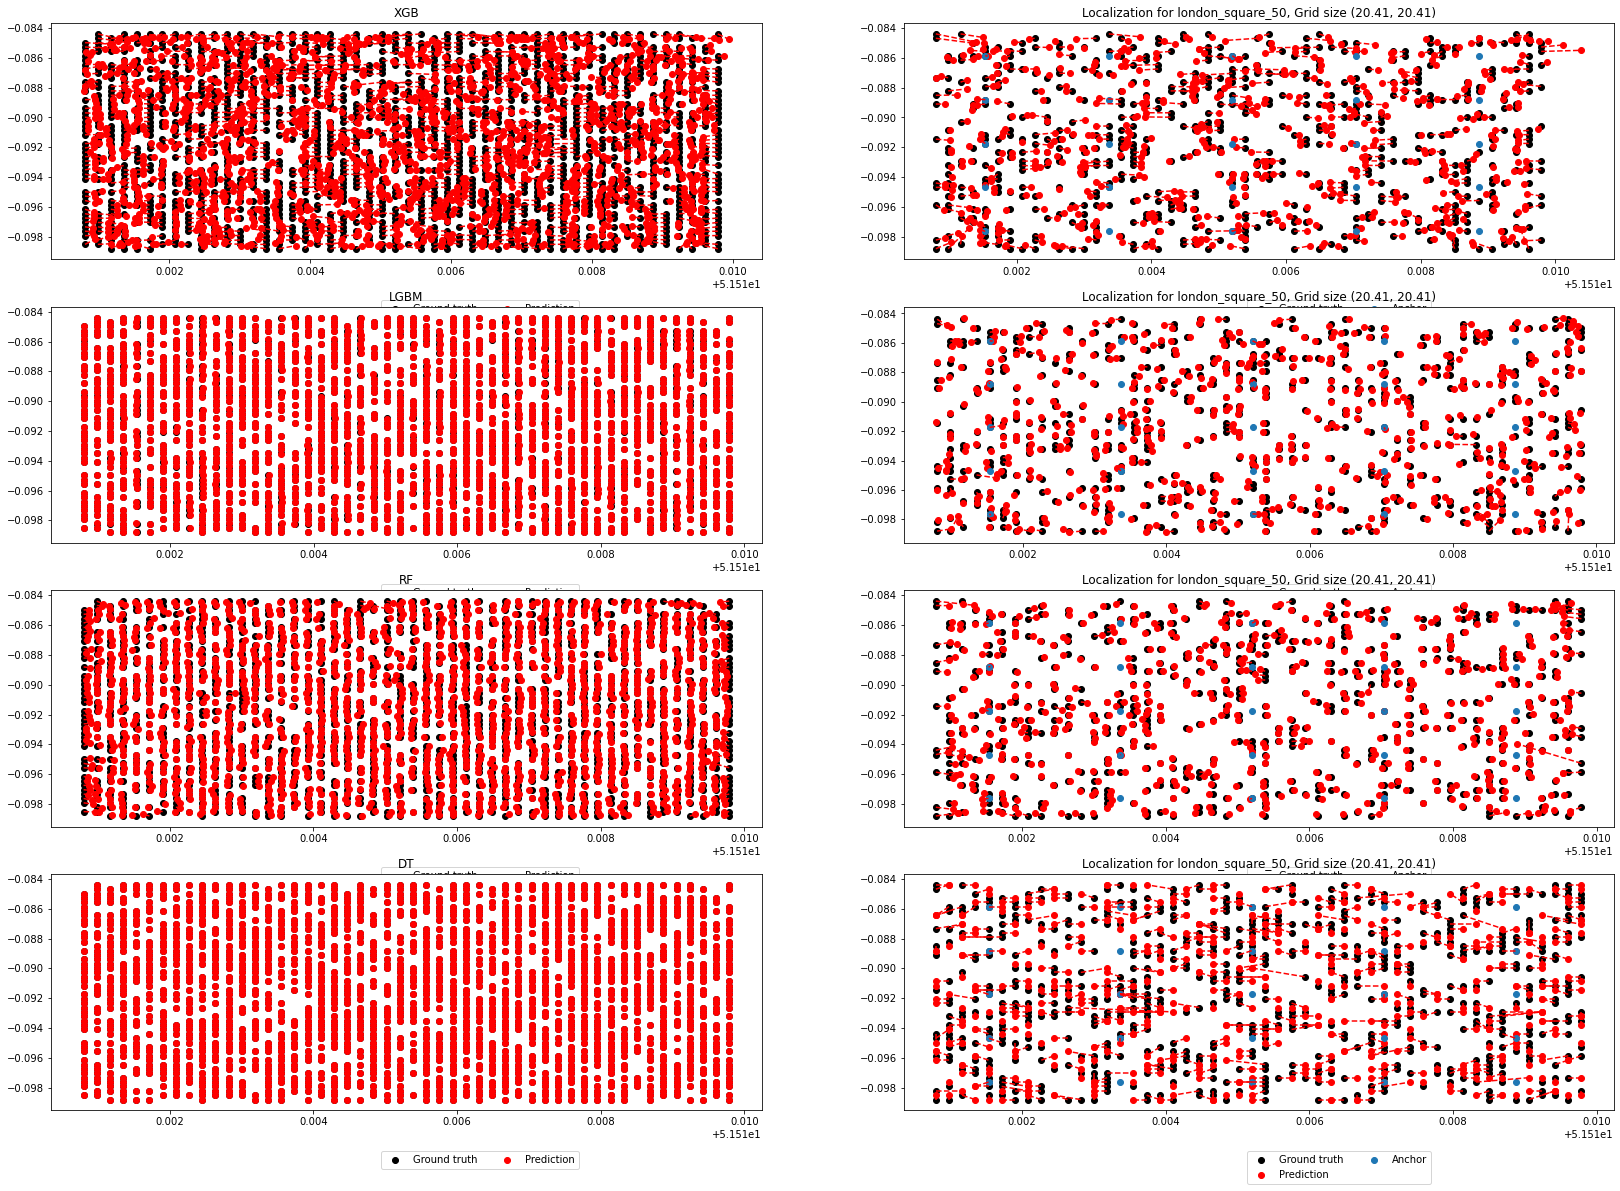

In [13]:
for config, pp in pipes_fitting.items():
    plt.figure()
    tmp = VisualizeResult(pp, config)
    tmp.scatter_pipes()
    # plt.title(config)

## Analyzing the impact of grid size

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1376

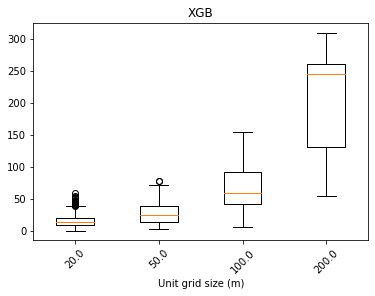

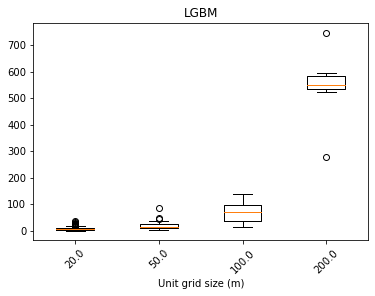

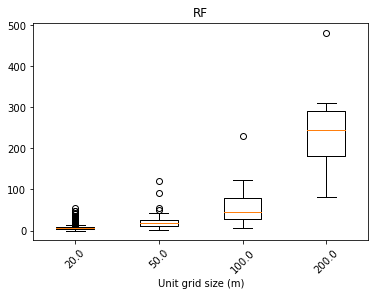

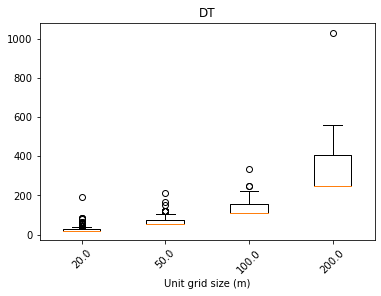

In [44]:
for ind, mod in enumerate(model_ls):
    d = []
    _ = plt.figure()
    for config in reversed(config_ls):
        d.append(pipes_fitting[config].dist_all[ind])

    plt.title(mod)
    plt.boxplot(d)
    plt.xticks(np.arange(len(d))+1, gs_ls, rotation=45)
    plt.xlabel('Unit grid size (m)')

### Analyzing relative error with increasing grid size

In [40]:
medians_all = []
for ind, mod in enumerate(model_ls):
    means = []
    medians = []
    for config in reversed(config_ls):
        means.append(pipes_fitting[config].d_error[ind])
        medians.append(pipes_fitting[config].d_medians[ind])

    medians_all.append(medians)

Text(0.5, 1.0, 'Relative error w.r.t grid size')

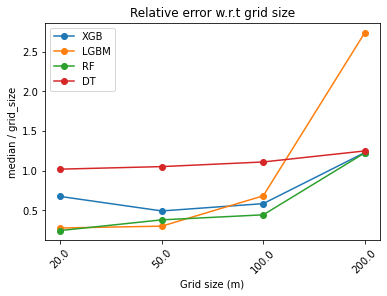

In [39]:
for i, m in enumerate(medians_all):
    plt.plot(np.arange(len(m))+1, m / gs_ls, 'o-', label=model_ls[i])

plt.ylabel('median / grid_size')
plt.xlabel('Grid size (m)')
plt.legend()
_ = plt.xticks(np.arange(len(d))+1, gs_ls, rotation=45)
plt.title('Relative error w.r.t grid size')